# Mask GAN

I want to try to use a GAN to make the output masks better. The generator will be the UNet that outputs the masks, while the discriminator will try to distinguish between real masks and generated masks.

In [1]:
import monai
from monai.networks.nets import UNet, Discriminator
from monai.transforms import (
    Compose,
    LoadNiftid,
    ScaleIntensityd,
    NormalizeIntensityd,
    AddChanneld,
    ToTensord,
    RandSpatialCropd,
    RandCropByPosNegLabeld,
    CropForegroundd,
    Identityd,
)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import pytorch_lightning as pl
from sklearn.model_selection import train_test_split

In [2]:
class MaskGAN(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        
        self.generator = UNet(
            dimensions=3,
            in_channels=1,
            out_channels=2,
            channels=(64, 128, 258, 512, 1024),
            strides=(2, 2, 2, 2),
            norm=monai.networks.layers.Norm.BATCH,
            dropout=0,
        )
        
        self.discriminator = Discriminator(
            in_shape=hparams['patch_size'],
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            norm=monai.networks.layers.Norm.BATCH,
        )
        
        self.generated_masks = None
        self.sample_masks = []
    
    # Data setup
    def setup(self, stage):
        data_dir = 'data/'
        
        # Train imgs/masks
        train_imgs = []
        with open(data_dir + 'train_imgs.txt', 'r') as f:
            train_imgs = [image.rstrip() for image in f.readlines()]

        train_masks = []
        with open(data_dir + 'train_masks.txt', 'r') as f:
            train_masks = [mask.rstrip() for mask in f.readlines()]
        
        train_dicts = [{'image': image, 'mask': mask} for (image, mask) in zip(train_imgs, train_masks)]
        
        train_dicts, val_dicts = train_test_split(train_dicts, test_size=0.2)
        
        # Basic transforms
        data_keys = ["image", "mask"]
        data_transforms = Compose(
            [
                LoadNiftid(keys=data_keys),
                AddChanneld(keys=data_keys),
                NormalizeIntensityd(keys="image"),
                RandCropByPosNegLabeld(
                    keys=data_keys,
                    label_key="mask",
                    spatial_size=self.hparams.patch_size,
                    num_samples=4,
                    image_key="image"
                ),
            ]
        )
        
        self.train_dataset = monai.data.CacheDataset(
            data=train_dicts,
            transform=Compose(
                [
                    data_transforms,
                    ToTensord(keys=data_keys)
                ]
            ),
            cache_rate=1.0
        )
        
        self.val_dataset = monai.data.CacheDataset(
            data=val_dicts,
            transform=Compose(
                [
                    data_transforms,
                    ToTensord(keys=data_keys)
                ]
            ),
            cache_rate=1.0
        )
        
    def train_dataloader(self):
        return monai.data.DataLoader(
            self.train_dataset, batch_size=self.hparams.batch_size, shuffle=True, num_workers=hparams.num_workers
        )

    def val_dataloader(self):
        return monai.data.DataLoader(
            self.val_dataset, batch_size=self.hparams.batch_size, num_workers=hparams.num_workers
        )
    
    # Training setup
    def forward(self, image):
        return self.generator(image)
    
    def generator_loss(self, y_hat, y):
        dice_loss = monai.losses.DiceLoss(
            to_onehot_y=True,
            softmax=True
        )
        return dice_loss(y_hat, y)
    
    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        inputs, labels = batch['image'], batch['mask']
        batch_size = inputs.size(0)
        # Generator training
        if optimizer_idx == 0:
            self.generated_masks = self(inputs)
            
            # Loss from difference between real and generated masks
            g_loss = self.generator_loss(
                self.generated_masks,
                labels
            )
            
            # Loss from discriminator
            # The generator wants the discriminator to be wrong,
            # so the wrong labels are used
            fake_labels = torch.ones(batch_size, 1).cuda(inputs.device.index)
            d_loss = self.adversarial_loss(
                self.discriminator(self.generated_masks.argmax(1).type(torch.FloatTensor).cuda(inputs.device.index)),
                fake_labels
            )
            
            avg_loss = (g_loss + d_loss) / 2
            
            self.logger.log_metrics({"g_train/g_loss": g_loss}, self.global_step)
            self.logger.log_metrics({"g_train/d_loss": d_loss}, self.global_step)
            self.logger.log_metrics({"g_train/tot_loss": avg_loss}, self.global_step)
            return {'loss': avg_loss}
            
        # Discriminator trainig
        else:
            # Learning real masks
            real_labels = torch.ones(batch_size, 1).cuda(inputs.device.index)
            real_loss = self.adversarial_loss(
                self.discriminator(labels.squeeze(1).type(torch.FloatTensor).cuda(inputs.device.index)),
                real_labels
            )
            
            # Learning "fake" masks
            fake_labels = torch.zeros(batch_size, 1).cuda(inputs.device.index)
            fake_loss = self.adversarial_loss(
                self.discriminator(self.generated_masks.argmax(1).detach().type(torch.FloatTensor).cuda(inputs.device.index)),
                fake_labels
            )
            
            avg_loss = (real_loss + fake_loss) / 2
            
            self.logger.log_metrics({"d_train/real_loss": real_loss}, self.global_step)
            self.logger.log_metrics({"d_train/fake_loss": fake_loss}, self.global_step)
            self.logger.log_metrics({"d_train/tot_loss": avg_loss}, self.global_step)
            
            return {'loss': avg_loss}
    
    def configure_optimizers(self):
        lr = self.hparams.lr
        g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=lr)
        d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [g_optimizer, d_optimizer], []
    
    def validation_step(self, batch, batch_idx):
        inputs, labels = (
            batch["image"],
            batch["mask"],
        )
        outputs = self(inputs)
        
        # Sample masks
        if self.current_epoch != 0:
            image = outputs[0].argmax(0)[:, :, 8].unsqueeze(0).detach()
            self.sample_masks.append(image)
        
        loss = self.generator_loss(outputs, labels)
        return {"val_loss": loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        self.logger.log_metrics({"val/loss": avg_loss}, self.current_epoch)
        
        if self.current_epoch != 0:
            grid = torchvision.utils.make_grid(self.sample_masks)
            self.logger.experiment.add_image('sample_masks', grid, self.current_epoch)
            self.sample_masks = []
        
        return {"val_loss": avg_loss}

In [ ]:
from argparse import Namespace

args = {
    'batch_size': 2,
    'lr': 0.001,
    'patch_size': [256, 256, 16],
    'num_workers': 6,
}

hparams = Namespace(**args)

In [ ]:
model = MaskGAN(hparams)

In [3]:
%load_ext tensorboard
%tensorboard --logdir models/7-03-2020_MaskGAN/tb_logs/

Reusing TensorBoard on port 6006 (pid 7761), started 10:12:22 ago. (Use '!kill 7761' to kill it.)

In [ ]:
NAME = 'models/7-03-2020_MaskGAN/'
logger = pl.loggers.TensorBoardLogger(NAME + "tb_logs/", name='')

# Callbacks
early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(filepath=NAME + 'checkpoints/')


trainer = pl.Trainer(
    checkpoint_callback=checkpoint_callback,
    early_stop_callback=early_stopping,
    check_val_every_n_epoch=5,
    gpus=1,
    max_epochs=1000,
    logger=logger,
)

trainer.fit(model)

## Evaluation

In [3]:
import os
import glob
import random
import matplotlib.pyplot as plt

In [4]:
model = MaskGAN.load_from_checkpoint('models/7-03-2020_MaskGAN/_ckpt_epoch_24.ckpt')

In [5]:
def select_animals(images, masks, animals):
    """Returns the images and masks as a dictionary for specific animals."""
    filtered_images = []
    filtered_masks = []
    for animal in animals:
        filtered_images.extend(filter(lambda x: 'PSEA' + str(animal) in x, images))
        filtered_masks.extend(filter(lambda x: 'PSEA' + str(animal) in x, masks))
    return [{'image': image_file, 'mask': mask_file} for image_file, mask_file in zip(filtered_images, filtered_masks)]

### Data collection
data_dir = 'data/'
print('Available directories: ', os.listdir(data_dir))

# Get paths for images and masks, organize into dictionaries
images = sorted(glob.glob(data_dir + '**/*CTImg*', recursive=True))
masks = sorted(glob.glob(data_dir + '**/*Mask*', recursive=True))
data_dicts = [{'image': image_file, 'mask': mask_file} for image_file, mask_file in zip(images, masks)]

test_dicts = select_animals(images, masks, [12])
data_keys = ['image', 'mask']

data_keys = ['image', 'mask']

test_transforms = Compose(
    [
        LoadNiftid(keys=data_keys),
        AddChanneld(keys=data_keys),
        NormalizeIntensityd(keys="image"),
        RandSpatialCropd(
            keys=data_keys,
            roi_size=(256, 256, 16),
            random_size=False
        ),
        ToTensord(keys=data_keys),
    ]
)

test_dataset = monai.data.Dataset(
    data=test_dicts,
    transform=test_transforms,
)

Available directories:  ['PSEA12 Baseline', 'PSEA13 PostGel', 'PSEA27 PostGel', 'PSEA25 Baseline', 'PSEA12 PostGel', 'test_masks.txt', '.ipynb_checkpoints', 'PSEA14 Baseline', 'train_imgs.txt', 'PSEA14 PostGel', 'PSEA20 PostMI', 'PSEA18 PostMI', 'PSEA12 PostMI', 'PSEA18 Baseline', 'PSEA27 PostMI', 'PSEA13 Baseline', 'PSEA20 PostGel', 'PSEA25 PostMI', 'PSEA27 Baseline', 'PSEA13 PostMI', 'test_imgs.txt', 'train_masks.txt', 'PSEA25 PostGel', 'PSEA18 PostGel']


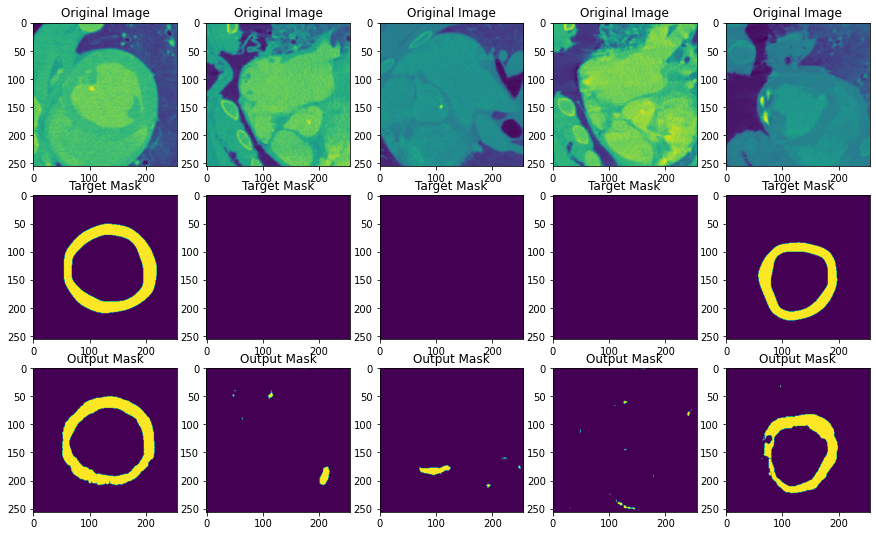

In [8]:
test_samples = random.sample(range(len(test_dataset)), 5)
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
slice_depth = 8
for i in range(5):
    sample = test_dataset[test_samples[i]]
    axs[0, i].imshow(sample['image'][0, :, :, slice_depth])
    axs[0, i].set_title('Original Image')

    axs[1, i].imshow(sample['mask'][0, :, :, slice_depth])
    axs[1, i].set_title('Target Mask')
    
    test_image = sample['image'].unsqueeze(0) #.squeeze(4)
    test_mask = model(test_image)
    test_mask = test_mask.argmax(1).squeeze(0).detach()
    axs[2, i].imshow(test_mask[:, :, slice_depth])
    axs[2, i].set_title('Output Mask')

plt.savefig('results/' + 'MaskGAN' + '.png')